The data extraction notebook was about extracting all the relevant features from the dataset
We have extracted MFCCs and spectral centroids for 7994/8000 tracks
Now we will apply treatments to these features, starting by dimensionality reduction and clustering

In [42]:
# Make imports
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure


We have 2 dataframes to load : the features extracted from the tracks, and the metadata about the tracks (namely the genre)

In [25]:
# Load the data into dataframes
features = pd.read_csv('data/extracted_features.csv')
metadata = pd.read_csv('data/metadata.csv')

# Remove the tracks that were not found in the features dataset from the metadata
metadata = metadata[metadata['track_id'].isin(features['track_id'])]

print (metadata.shape)
print (features.shape)

(7994, 4)
(7994, 148)


We will first try to reduce the dimensionality of our data from 148 to just 2 in order to be able to visualize the data points
Then we'll apply a simple K-means clustering (and it's even better because we know the expected numebr of clusters) on our data to see how it does
Note that reducing the dimensionality from 148 to 2 will lead to massive loss and therefore the clustering might not be great
We could (and will probably) also reduce the dimensionality to a bit more like 10 features, apply a K-means and evaluate it by comparing the clusters to the real values for the genre (the evaluation will be a bit of a pain) 
In order to find the best number of dimensions we can apply PCA to all features (not reducing anything) and checking the contributions from the different attributes to the PCA
Note that for the data to be mapped we need to have the dataframes ordered in the same way : the first element of the metadata corresponds to the same track as the first element of the features dataframe
For this, it is possible to merge the two dataframes in oder to have all in one

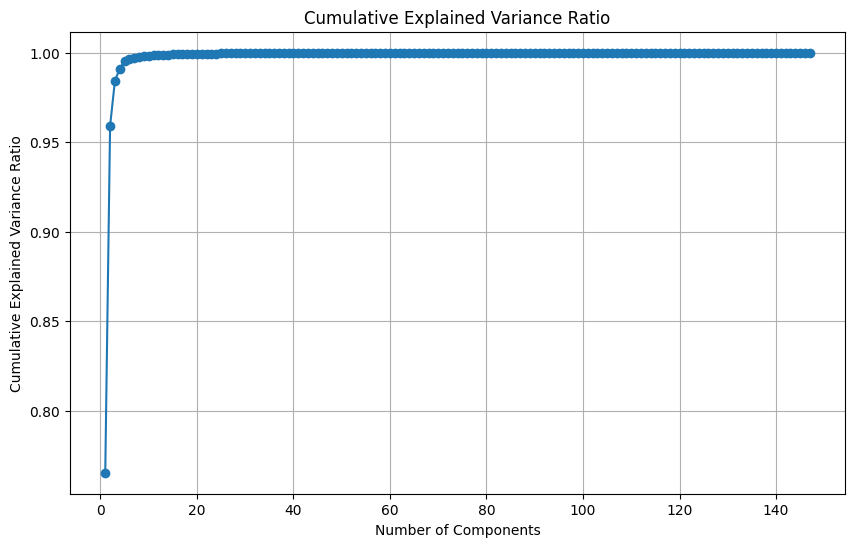

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [54]:
# Drop the track_id column first
X = features.drop(columns=['track_id']).values

# Dimensionality reduction (PCA)
pca = PCA(n_components=X.shape[1])  # Keep all components initially
X_pca = pca.fit_transform(X)

# Calculate cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

cumulative_explained_variance_ratio < 0.99

As we can see, 95% of the variance can be explained with 1 component, and 99% with 3, so 2 components is enough for our use case especially because it allows us to visualise the data
Now that we have our clusters, we can evaluate them, not visually but mathematically speaking

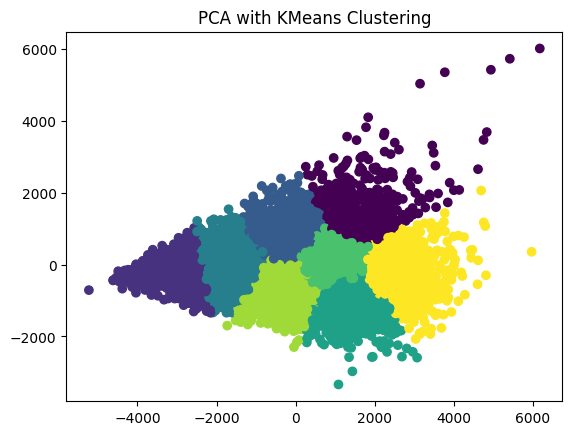

In [55]:
# Dimensionality reduction using PCA
# First, reducing to 2 dimensions for visualization

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering using KMeans with 8 clusters because we know that there are 8 genres
n_clusters = 8
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit(X_pca)

# Visualize the clusters
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters.labels_)
plt.title('PCA with KMeans Clustering')
plt.show()


Even with only 2 components for PCA the Kmeans yields a very good result as we can see on the graph
The fact that the clusters are very well defined means that it should be pretty easy to classify the data and also that the features we extracted are relevant !
I will however try to check how many dimensions should be kept and try PCA with that

In [64]:
# Evaluate clustering performance
true_labels = metadata['track_genre'].values

silhouette = silhouette_score(X_pca, clusters.labels_)
ari = adjusted_rand_score(true_labels, clusters.labels_)
nmi = normalized_mutual_info_score(true_labels, clusters.labels_)
h, c, v = homogeneity_completeness_v_measure(true_labels, clusters.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Homogeneity: {h}")
print(f"Completeness: {c}")
print(f"V-measure: {v}")
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Normalized Mutual Information (NMI): {nmi}")

Silhouette Score: 0.3391077082648229
Homogeneity: 0.10329527639929258
Completeness: 0.10502800921333921
V-measure: 0.10415443678756468
Adjusted Rand Index (ARI): 0.06081721484810713
Normalized Mutual Information (NMI): 0.10415443678756468


#TODO : analyse the results of the clustering
Let's interpret each of the evaluation metrics based on the provided values:

Silhouette Score: 0.3391077082648229
This indicates moderate clustering quality. A silhouette score between 0.25 and 0.5 suggests that the clusters are reasonably well-separated.
The value of 0.3391 indicates that the average distance between samples in the same cluster is larger than the distance between samples in different clusters, which is a positive sign.

Homogeneity: 0.10329527639929258
This value indicates low homogeneity, suggesting that the clusters are not very pure. It means that the clusters contain samples from multiple classes, rather than being composed mostly of samples from a single class.

Completeness: 0.10502800921333921
Similarly to homogeneity, the low completeness value suggests that each class is not entirely assigned to a single cluster. Some samples from each class might be spread across multiple clusters.

V-measure: 0.10415443678756468
V-measure is the harmonic mean of homogeneity and completeness. The low value indicates that neither homogeneity nor completeness is high, resulting in a relatively low overall V-measure.

Adjusted Rand Index (ARI): 0.06081721484810713
This value suggests a slightly better than random clustering performance. ARI ranges from -1 to 1, where 1 indicates perfect clustering agreement with the ground truth labels, 0 indicates random clustering, and negative values indicate clustering worse than random.

Normalized Mutual Information (NMI): 0.10415443678756468
NMI measures the mutual information between the true and predicted cluster labels, normalized by the total entropy of the labels. The low value suggests limited mutual information between the true and predicted labels, indicating that the clustering algorithm does not capture the true label information well.

In summary, the provided metrics indicate that while there is some structure in the clustering, it is not strong. The clusters are moderately separated according to the silhouette score, but they are not very homogeneous or complete. The ARI and NMI scores suggest that the clustering does not agree strongly with the ground truth labels. These results indicate that there may be room for improvement in the clustering algorithm or in the data preprocessing steps.

We can try with 5 dimensions for clustering and see how it affects the metrics (because with 5 dimensions we have more than 99% of the variance explained)

In [65]:
# Perform PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Clustering using KMeans with 8 clusters because we know that there are 8 genres
n_clusters = 8
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit(X_pca)

# We can't visualize the clusters

# Evaluate clustering performance
silhouette = silhouette_score(X_pca, clusters.labels_)
ari = adjusted_rand_score(true_labels, clusters.labels_)
nmi = normalized_mutual_info_score(true_labels, clusters.labels_)
h, c, v = homogeneity_completeness_v_measure(true_labels, clusters.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Homogeneity: {h}")
print(f"Completeness: {c}")
print(f"V-measure: {v}")
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Normalized Mutual Information (NMI): {nmi}")

Silhouette Score: 0.2926022584443271
Homogeneity: 0.10410880273866845
Completeness: 0.106452775227003
V-measure: 0.10526774242638619
Adjusted Rand Index (ARI): 0.06142110878924854
Normalized Mutual Information (NMI): 0.10526774242638617


The results are almost the same, even a bit worse it seems like, so we will just stick with our 2 components
Either way once we get to the classification task we won't be using PCA anymore, we will probably use all the features for our classifiers => this can be discussed, how many parameters we give to the model can affect the performances